This script excludes segmented cell body based on computed features.

Run the cells below step by step and don't forget to set your values that marked by 'USER INPUT' blocks.


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns

from skimage import io

import matplotlib
matplotlib.use('nbAgg') 

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb

In [2]:
def distinct_color(n):
    '''
    Return list of RGB values used to define a ListedColormap in matplotlib.
    '''
    clc = []
    for i in np.arange(0,360,360./n):
        h = i / 360.
        clc.append(hsv_to_rgb(h,1,1))
        
    clc = np.array(clc)
    shuffle_idx = np.random.permutation(n)
    clc = clc[shuffle_idx]
    
    clc[0] = (0.,0.,0.) # assign first item as black corresponding to background
    
    return clc.tolist()

# Reading files

Specifying directory and files here.

In [3]:
'''USER INPUT
Base directory (basedir) containing images to be executed.

I assume that all images and their intermediated results were saved within this basedir.

Examples
--------
Windows: basedir = r'E:\Perso\Phan\EXingi\cellbody\output\Test'
Linux: basedir = r'../output/Test'

'''
basedir = r'../../../Data/dataset_20241113/images'


'''USER INPUT
List of images (imagefiles) are taken from the basedir.
If the variable is empty, then all images within the basedir will be considered.

Examples
--------
Empty list (i.e. all images are taken): imagefiles = []
A few images in the basedir: imagefiles = ['CXCR HET 3 FEMALE LPS 4 DAYS_90-160 um zoom 4 im 5', 'CXCR HET 3 FEMALE LPS 4 DAYS_90-140 um zoom 4 im 3']

'''
imagefiles = []


if len(imagefiles)==0:
    files = glob.glob(os.path.join(basedir,'L_*.tif'))
    files = [os.path.join(os.path.dirname(f),os.path.basename(f).split('L_')[1]) for f in files]
else:
    files = []
    for f in imagefiles:
        files.append(os.path.join(basedir,f+'.tif'))
print('List of images:')
it = 1
for f in files:
    print(it,':',os.path.basename(f))
    it += 1

List of images:
1 : CXCR HET 1 gIba1,rCD68_Tomh 3-Position001.tif
2 : CXCR HET 1 gIba1,rCD68_Tomh 3-Position002.tif
3 : CXCR HET 1 gIba1,rCD68_Tomh 3-Position003.tif


# Exploiting the features

The aim of this part is to provide first look on the features used to filtered out the objects.

<IPython.core.display.Javascript object>


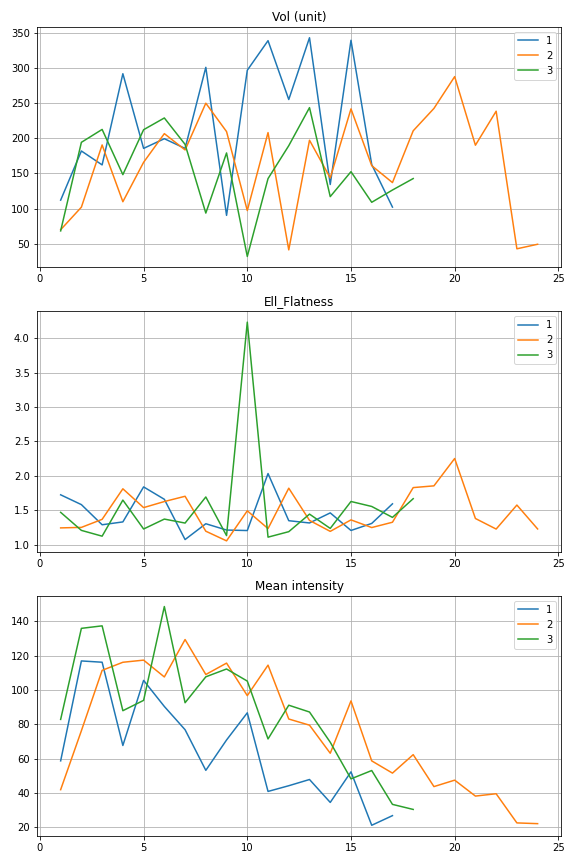

In [4]:
# First plot the features
fig = plt.figure(figsize=(8,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for f in files:
    dname = os.path.dirname(f)
    fname = os.path.basename(f)
    df_shapef = pd.read_csv(os.path.join(dname,'M_'+fname.split('.tif')[0]+'.csv'))
    df_intenf = pd.read_csv(os.path.join(dname,'Q_'+fname.split('.tif')[0]+'.csv'))
    
    ax1.plot(df_shapef['Label'],df_shapef['Vol (unit)'])
    ax2.plot(df_shapef['Label'],df_shapef['Ell_Flatness'])
    ax3.plot(df_intenf['Label'],df_intenf['Mean'])

ax1.legend(range(1,len(files)+1));
ax1.set_title('Vol (unit)');
ax1.grid();

ax2.legend(range(1,len(files)+1));
ax2.set_title('Ell_Flatness');
ax2.grid();

ax3.legend(range(1,len(files)+1));
ax3.set_title('Mean intensity');
ax3.grid();

plt.tight_layout();

# Setting parameters

Specifying the parameters here.

In [5]:
'''USER INPUT
Specifying thresholds used to filter out the objects after observing the plots from the above section.

'''
# Min volume
vol_thr = 110 

# Max flatness
flatness_thr = 3.5 

# Min mean intensity
intensity_thr = 60 

# Touching x, y or z
exclude_x = True
exclude_y = True
exclude_z = False

# Filtering

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


-------------
Image: CXCR HET 1 gIba1,rCD68_Tomh 3-Position001.tif
Labels were excluded: [ 1.  3.  8.  9. 11. 12. 13. 14. 15. 16. 17.]
Labels were remained: [ 2  4  5  6  7 10]


<IPython.core.display.Javascript object>


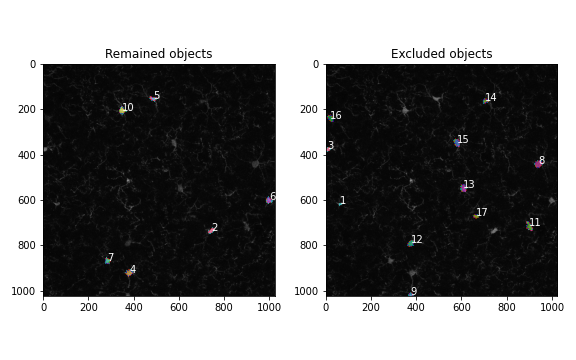

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


-------------
Image: CXCR HET 1 gIba1,rCD68_Tomh 3-Position002.tif
Labels were excluded: [ 1.  2.  4.  9. 10. 12. 16. 17. 19. 20. 21. 22. 23. 24.]
Labels were remained: [ 3  5  6  7  8 11 13 14 15 18]


<IPython.core.display.Javascript object>


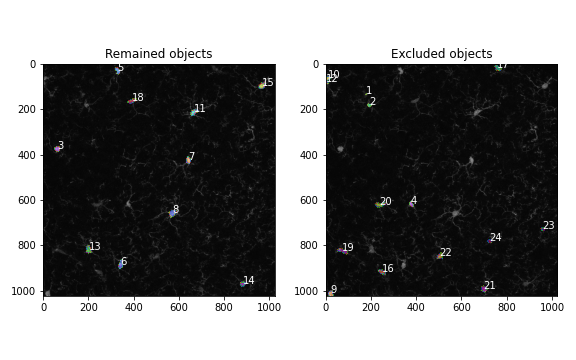

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


-------------
Image: CXCR HET 1 gIba1,rCD68_Tomh 3-Position003.tif
Labels were excluded: [ 1.  8. 10. 15. 16. 17. 18.]
Labels were remained: [ 2  3  4  5  6  7  9 11 12 13 14]


<IPython.core.display.Javascript object>


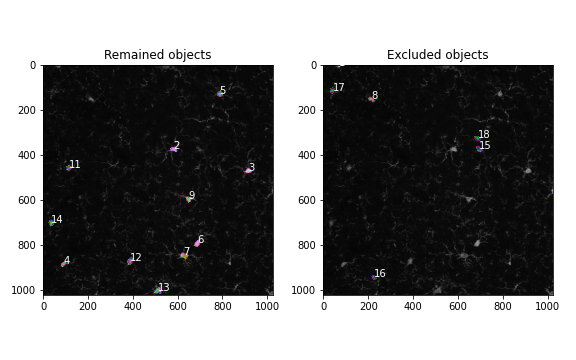

In [6]:
for f in files:
    # Microglia stack
    microglia = io.imread(os.path.join(os.path.dirname(f),'S_'+os.path.basename(f)))

    dname = os.path.dirname(f) # directory name
    fname = os.path.basename(f) # file name

    print('-------------')
    print('Image:',fname)

    # Cellbody object labels
    labels = io.imread(os.path.join(dname,'L_'+fname)).astype(int)

    # Measured object features
    df_shapef = pd.read_csv(os.path.join(dname,'M_'+fname.split('.tif')[0]+'.csv'))
    df_intenf = pd.read_csv(os.path.join(dname,'Q_'+fname.split('.tif')[0]+'.csv'))
    
    # Drop columns with NaN
    df_shapef = df_shapef.dropna(how='all', axis=1)
    df_intenf = df_intenf.dropna(how='all', axis=1)

    # Set Label as index
    df_shapef.set_index('Label',inplace=True)
    df_intenf.set_index('Label',inplace=True)

    # Add new column mark excluded object
    df_shapef['IsExcluded'] = 0

    # Initialize list of object labels to be excluded
    items = []

    # Get x, y, z coordinates of all objects in the image stack
    zlen, ylen, xlen = labels.shape
    pixel_coors = np.argwhere(labels != 0)
    z_coors, y_coors, x_coors = pixel_coors[:,0], pixel_coors[:,1], pixel_coors[:,2]

    # Object touches X border
    if exclude_x == True:
        ix = np.argwhere((x_coors==0)|(x_coors==xlen-1)).flatten()
        x_labels = np.setdiff1d(np.unique(labels[z_coors[ix],y_coors[ix],x_coors[ix]]),[0])
    else:
        x_labels = []

    items = np.union1d(items,x_labels)

    # Object touches Y border
    if exclude_y == True:
        ix = np.argwhere((y_coors==0)|(y_coors==ylen-1)).flatten()
        y_labels = np.setdiff1d(np.unique(labels[z_coors[ix],y_coors[ix],x_coors[ix]]),[0])
    else:
        y_labels = []

    items = np.union1d(items,y_labels)

    # Object touches Z border
    if exclude_z == True:
        ix = np.argwhere((z_coors==0)|(z_coors==zlen-1)).flatten()
        z_labels = np.setdiff1d(np.unique(labels[z_coors[ix],y_coors[ix],x_coors[ix]]),[0])
    else:
        z_labels = []

    items = np.union1d(items,z_labels)

    # Shape conditions
    shape_labels = df_shapef[(df_shapef["Vol (unit)"]<vol_thr)|(df_shapef["Ell_Flatness"]>flatness_thr)].index.values
    items = np.union1d(items,shape_labels)

    # Intensity conditions
    inten_labels = df_intenf[(df_intenf["Mean"]<intensity_thr)].index.values
    items = np.union1d(items,inten_labels)

    # Label stack containing remained objects
    good_labels = labels.copy()
    for lbl in items:
        good_labels[labels==lbl] = 0
        df_shapef.at[lbl,'IsExcluded'] = 1

    # Label stack containing excluded objects
    excluded_labels = labels.copy()
    for lbl in np.setdiff1d(df_shapef.index.values,items):
        excluded_labels[labels==lbl] = 0

    print("Labels were excluded:",items)
    print("Labels were remained:",np.setdiff1d(df_shapef.index.values,items))

    # Save to csv
    df_shapef.reset_index().to_csv(os.path.join(dname,'M_'+fname.split('.tif')[0]+'.csv'),index=False)

    # Plot results
    # Custom colormap to overlay lables on the microglia image
    mycmap = ListedColormap(distinct_color(labels.max()+1))

    fig = plt.figure(figsize=(8,5))
    fig.patch.set_facecolor('white')

    ax = fig.add_subplot(121)
    ax.imshow(np.max(microglia,axis=0),cmap="gray")
    ax.imshow(np.max(good_labels,axis=0),cmap=mycmap,alpha=0.4);
    sdf = df_shapef[df_shapef['IsExcluded']==0]
    for irow in range(len(sdf)): 
        ax.text(sdf.iloc[irow]['CX (pix)'],sdf.iloc[irow]['CY (pix)'],sdf.index[irow],c='w')
    ax.set_title("Remained objects")

    ax = fig.add_subplot(122)
    ax.imshow(np.max(microglia,axis=0),cmap="gray")
    ax.imshow(np.max(excluded_labels,axis=0),cmap=mycmap,alpha=0.4);
    sdf = df_shapef[df_shapef['IsExcluded']==1]
    for irow in range(len(sdf)): 
        ax.text(sdf.iloc[irow]['CX (pix)'],sdf.iloc[irow]['CY (pix)'],sdf.index[irow],c='w')
    ax.set_title("Excluded objects")

    plt.tight_layout();

    # Save results
    fig.savefig(os.path.join(dname,'F_'+fname.split('.tif')[0]+'.png'),dpi=300)